In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.special
from classy import Class
import mpmath
mpmath.mp.dps=30
from IPython.display import clear_output

In [2]:
def sph_Bessel(l,x):
    return np.sqrt(np.pi/(2*x))*scipy.special.jn(l+0.5, x)

def hyperspherical(K,nu,l,chi):
    if K==0:
        return sph_Bessel(l,nu*chi)
    sqrtN = mpmath.fprod(np.sqrt(nu*nu-K*np.arange(1,l+1)**2))
    Phi = np.zeros(chi.shape)
    
    if K==-1:
        legtype = 3
        n = -0.5+nu*1j
        m = -0.5-l
    else:
        legtype = 2
        n = -0.5+nu
        m = -0.5-l
    for idx, chival in enumerate(chi):
        if K==-1:
            cosK = mpmath.cosh(chival)
            sinK = mpmath.sinh(chival)
        else:
            cosK = mpmath.cos(chival)
            sinK = mpmath.sin(chival)
        Phi[idx] = float(sqrtN*mpmath.sqrt(mpmath.pi/(2*sinK))*
               mpmath.re(mpmath.legenp(n, m, cosK, type=legtype)))
    return Phi

def hyperspherical_geom(K,nu,l,chi):
    if K==0:
        return sph_Bessel(l,nu*chi)
    sqrtN = mpmath.fprod(np.sqrt(nu*nu-K*np.arange(1,l+1)**2))
    Phi = np.zeros(chi.shape)
    
    if K==-1:
        legtype = 3
        n = -0.5+nu*1j
        m = -0.5-l
    else:
        legtype = 2
        n = -0.5+nu
        m = -0.5-l
    for idx, chival in enumerate(chi):
        if K==-1:
            cosK = mpmath.cosh(chival)
            sinK = mpmath.sinh(chival)
        else:
            cosK = mpmath.cos(chival)
            sinK = mpmath.sin(chival)
        hyp = mpmath.hyp2f1(n+1,-n,1-m,0.5-0.5*cosK)
        leg = (K*(1+cosK)/(1-cosK))**(0.5*m)/mpmath.gamma(1-m)*hyp
        Phi[idx] = float(sqrtN*mpmath.sqrt(mpmath.pi/(2*sinK))*mpmath.re(leg))
    return Phi

def hyperspherical_combined(K,nu,l,chi):
    if K==0:
        return sph_Bessel(l,nu*chi)
    sqrtN = mpmath.fprod(np.sqrt(nu*nu-K*np.arange(1,l+1)**2))
    Phi = np.zeros(chi.shape)
    
    if K==-1:
        legtype = 3
        n = -0.5+nu*1j
        m = -0.5-l
    else:
        legtype = 2
        n = -0.5+nu
        m = -0.5-l
    for idx, chival in enumerate(chi):
        if K==-1:
            cosK = mpmath.cosh(chival)
            sinK = mpmath.sinh(chival)
        else:
            cosK = mpmath.cos(chival)
            sinK = mpmath.sin(chival)
        try:
            hyp = mpmath.hyp2f1(n+1,-n,1-m,0.5-0.5*cosK)
            leg = (K*(1+cosK)/(1-cosK))**(0.5*m)/mpmath.gamma(1-m)*hyp
            Phi[idx] = float(sqrtN*mpmath.sqrt(mpmath.pi/(2*sinK))*mpmath.re(leg))
        except:
            #Try using legenp instead:
            try:
                Phi[idx] = float(sqrtN*mpmath.sqrt(mpmath.pi/(2*sinK))*
                   mpmath.re(mpmath.legenp(n, m, cosK, type=legtype)))
            except:
                PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,np.array([chival]))
                print(PhiRec.shape)
                print('Both hyp2f1 and legenp failed to converge for (nu,l,chi)='+str([nu,l,chival])+'.')
                print('Recurrence method gives Phi=',PhiRec[0,-1])
                Phi[idx] = np.nan
    return Phi

def closed_hyperspherical(nu,l,chi):
    Phi = np.zeros(chi.shape)
    for idx, chival in enumerate(chi):
        Phi[idx] = (mpmath.power(2*mpmath.sin(chival),l)*mpmath.factorial(l)*
            mpmath.sqrt(mpmath.factorial(nu-l-1)/nu/mpmath.factorial(nu+l))*
            mpmath.gegenbauer(nu-l-1,l+1,mpmath.cos(chival)))
    return Phi

def get_hyper(K,nu,lvec,chi,use_gegen=False,use_geom=False):
    Phi = np.zeros((len(chi),len(lvec)))
    if K==1 and use_gegen==True:
        for l in lvec:
            Phi[:,l] = closed_hyperspherical(nu,l,chi)
    elif use_geom:
        print('using geom')
        for l in lvec:
            Phi[:,l] = hyperspherical_geom(K,nu,l,chi)
    else:
        for l in lvec:
            Phi[:,l] = hyperspherical(K,nu,l,chi)
    return Phi

def get_WKB(K,nu,lvec,chi):
    #Phi = np.zeros((len(chi),len(lvec)))
    Z = np.zeros((len(chi),len(lvec)))
    sgnZ = np.ones((len(chi),len(lvec)))
    e_vec = 1./np.sqrt(lvec*(lvec+1.))
    if K==-1:
        CscK = 1./np.sinh(chi)
        nucorr_array = np.ones((len(chi),len(lvec)))
        alpha = nu*e_vec
        chi_tp = np.arcsinh(1./alpha)
    else:
        CscK = 1./np.sin(chi)
        nuvec = nu-1./(8*lvec)+1./(16*lvec*lvec)
        nucorr_array, chi_array = np.meshgrid(nuvec/nu,chi)
        alpha = nuvec*e_vec
        chi_tp = np.arcsin(1./alpha)
        
    e_array, CscK2_array = np.meshgrid(e_vec,CscK*CscK)
    alpha_array, CscK_array = np.meshgrid(alpha,CscK)
    chi_tp_array, chi_array = np.meshgrid(chi_tp,chi)
    
    w = alpha_array/CscK_array
    w2 = w*w
    alpha2_array = alpha_array*alpha_array
    
    mask = chi_tp_array<chi_array
    sgnZ[mask] = -1
    
    if K==-1:
        #u = np.sqrt((1-w2)/(1+w2/alpha2_array))
        #v = np.sqrt((1-w2/alpha2_array)/(w2-1.))
        #chi<chi_tp
        t = np.sqrt((1.-w2[~mask])/(1.+w2[~mask]/alpha2_array[~mask]))
        Z[~mask] = np.arctanh(t)-alpha_array[~mask]*np.arctan(t/alpha_array[~mask])
        #chi>chi_tp
        Z[mask] = (alpha_array[mask]*np.log((np.sqrt(w2[mask]-1.)+np.sqrt(w2[mask]+alpha2_array[mask]))/
                                np.sqrt(1.+alpha2_array[mask]))+
        np.arctan(1./alpha_array[mask]*np.sqrt((w2[mask]+alpha2_array[mask])/
                                               (w2[mask]-1.)))-0.5*np.pi)
        #np.arctan(np.sqrt((w2[mask]+alpha2_array[mask])/(w2[mask]-1.))/alpha_array[mask])-0.5*np.pi)
        
        #e=0.
        #for idxchi, chival in enumerate(chi):
        #    for l in lvec:
        #        if l==0:
        #            continue
        #        ctp = np.arcsinh(np.sqrt(l*(l+1)/nu))
        #        integ = lambda xx: np.sqrt(np.abs(nu*nu/l/(l+1)-1./np.sinh(xx)**2))
        #        if chival<ctp:
        #            Z2[idxchi,l] = scipy.integrate.quad(integ,chival,ctp-e)[0]
        #        else:
        #            Z2[idxchi,l] = scipy.integrate.quad(integ,chival+e,ctp)[0]
        #print Z[:,4]/Z2[:,4]
                        
    else:
        #chi<chi_tp
        Z[~mask] = (np.arctanh(np.sqrt(1-w2[~mask])/np.sqrt(1-w2[~mask]/alpha2_array[~mask]))-
                    alpha_array[~mask]*np.log((np.sqrt(alpha2_array[~mask]-w2[~mask])+
                                               np.sqrt(1-w2[~mask]))/np.sqrt(alpha2_array[~mask]-1.)))
        t = np.sqrt((1-w2[mask]/alpha2_array[mask])/(w2[mask]-1.))
        Z[mask] = np.arctan(t)+alpha_array[mask]*np.arctan(1./(t*alpha_array[mask]))-0.5*np.pi
    #    Z[mask] = np.arctan(v[mask])+alpha_array[mask]*np.arctan(1./(v[mask]*alpha_array[mask]))-0.5*np.pi
    
    Z = 1.5*Z/e_array
    Ai = scipy.special.airy(sgnZ*Z**(2./3.))[0]
    Phi = (np.sqrt(np.pi*alpha_array)/(nu*nucorr_array)*Z**(1./6.)*
           np.abs(CscK2_array-alpha2_array)**(-0.25)*Ai*CscK_array)
    
#    Phi = (np.sqrt(np.pi*alpha_array)/nu*Z**(1./6.)*
#           np.abs(sinK_array**(-2)-alpha2_array)**(-0.25)/sinK_array*Ai)
    if lvec[0]==0:
        Phi[:,0] = 0
    return Phi 
           

In [3]:
cosmo = Class()
figwidth1 = 4.4 #=0.7*6.3
figwidth2 = 6.3
figwidth15 = 0.5*(figwidth1+figwidth2)
ratio = 8.3/11.7
figheight1 = figwidth1*ratio
figheight2 = figwidth2*ratio
figheight15 = figwidth15*ratio

lw=2
fs=12
labelfs=16

/var/folders/3p/q9fy22_j0px_k5m72psbsx6hftx5vr/T/ipykernel_6835/1234694400.py:119: RuntimeWarning: divide by zero encountered in true_divide
  e_vec = 1./np.sqrt(lvec*(lvec+1.))
/var/folders/3p/q9fy22_j0px_k5m72psbsx6hftx5vr/T/ipykernel_6835/1234694400.py:127: RuntimeWarning: divide by zero encountered in true_divide
  nuvec = nu-1./(8*lvec)+1./(16*lvec*lvec)
/var/folders/3p/q9fy22_j0px_k5m72psbsx6hftx5vr/T/ipykernel_6835/1234694400.py:127: RuntimeWarning: invalid value encountered in add
  nuvec = nu-1./(8*lvec)+1./(16*lvec*lvec)


(200, 1501) (200, 1501)


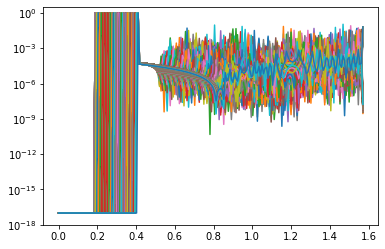

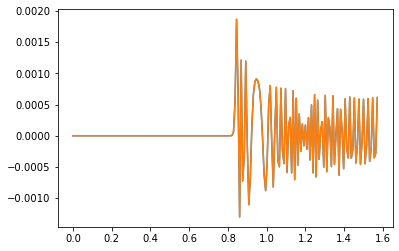

In [4]:
nu = 2000.0
lmax = 1500
K = 1

lvec = np.arange(lmax+1)

chi = np.linspace(1e-6,np.pi/2.-1e-6,200)
PhiRec = cosmo.hyperspherical_recurrence(lmax,nu,K,chi)
PhiWKB = get_WKB(K,nu,lvec,chi)
#PhiMP = get_hyper(K,nu,lvec,chi,use_gegen=False,use_geom=True)
PhiMP = PhiWKB

#print PhiWKB
print(PhiRec.shape,PhiWKB.shape)

for l in lvec:
    if l<980:
        continue
    mask = PhiRec[:,l]!=PhiMP[:,l]
    reldifs = np.ones(PhiRec[:,l].shape)*1e-17
    reldifs[mask] = np.abs(1.-PhiMP[mask,l]/PhiRec[mask,l])
    plt.semilogy(chi,np.abs(reldifs),label=r'$\ell='+str(l)+'$')

plt.ylim([1e-18,3])
plt.figure()
plt.plot(chi,PhiRec[:,-10])
#plt.figure()
plt.plot(chi,PhiWKB[:,-10])

#plt.xlim([0,0.01])

In [5]:
#Open plots
#lfracs = ['nu_minus_one',2./3,1./3,'ten']
lfracs = ['nu_minus_two',2./3,1./3,'ten']
nuvec = range(5,2001,1)
chi_over_tp = np.linspace(1e-6,10,500)
#CHI_OVER_TP, NU = np.meshgrid(chi_over_tp,nuvec)
reldif = np.ones((len(lfracs),len(nuvec),len(chi_over_tp)))

K=-1
for idxl, lfrac in enumerate(lfracs):
    print(str(idxl)+'/'+str(len(lfracs)))
    for idxnu, nu in enumerate(nuvec):
        if lfrac=='nu_minus_one':
            l=nu-1
        elif lfrac=='nu_minus_two':
            l=nu-2
        elif lfrac=='ten':
            l=10
        else:
            l = int(nu*lfrac)
        alpha = float(nu)/np.sqrt(l*(l+1.))
        chi_tp = np.arcsinh(1./alpha)
        chi = chi_over_tp*chi_tp
        PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,chi)
        PhiWKB = get_WKB(K,nu,np.array([l,l]),chi) 
        reldif[idxl,idxnu,:] = np.abs(1-PhiRec[:,-1]/PhiWKB[:,-1])

clear_output()
#Rename som variables for plotting later:
WKB_reldif_OPEN = reldif
WKB_chi_over_tp_OPEN = chi_over_tp
WKB_nu_OPEN = np.array(nuvec)



In [6]:
#Closed plots
#lfracs = ['nu_minus_one',2./3,1./3,'ten']
lfracs = ['nu_minus_two',2./3,1./3,'ten']
nuvec = range(5,2001,1)
chi = np.linspace(1e-6,np.pi/2-1e-6,500)
#chi_over_tp = np.linspace(1e-6,10,20)
#CHI_OVER_TP, NU = np.meshgrid(chi_over_tp,nuvec)
reldif_Closed = np.ones((len(lfracs),len(nuvec),len(chi)))

K=1
for idxl, lfrac in enumerate(lfracs):
    print("idxl = "+str(idxl)+'/'+str(len(lfracs)))
    for idxnu, nu in enumerate(nuvec):
        if lfrac=='nu_minus_one':
            l=nu-1
        elif lfrac=='nu_minus_two':
            llab = r'\nu-2'
        elif lfrac=='ten':
            l=min(nu-1,10)
        else:
            l = int(nu*lfrac)
#        alpha = nu/np.sqrt(l*(l+1))
#        chi_tp = np.arcsinh(1./alpha)
        PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,chi)
        PhiWKB = get_WKB(K,nu,np.array([l,l]),chi) 
        reldif_Closed[idxl,idxnu,:] = np.abs(1-PhiRec[:,-1]/PhiWKB[:,-1])

clear_output()
#Rename som variables for plotting later:
WKB_reldif_CLOSED = reldif_Closed
WKB_chi_CLOSED = chi
WKB_nu_CLOSED = np.array(nuvec)
       
        

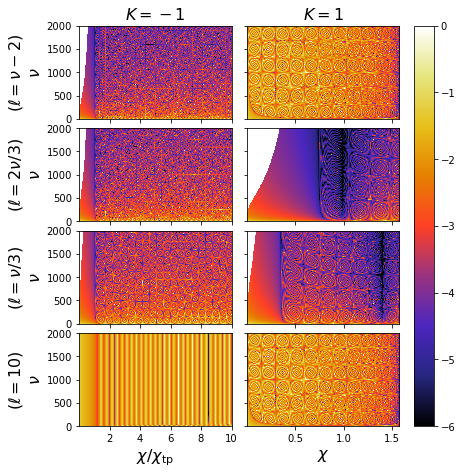

In [7]:
#'CMRmap'

fig, axes = plt.subplots(len(lfracs),2,sharex='col',sharey=True,figsize=(figwidth2,1.5*figheight2))
plt.colormaps()
models = ['Open','Closed']
for idx_g,geometry in enumerate(models):
    if geometry=='Open':
        x = WKB_chi_over_tp_OPEN
        y = WKB_nu_OPEN
        Z = WKB_reldif_OPEN
    else:
        x = WKB_chi_CLOSED
        y = WKB_nu_CLOSED
        Z = WKB_reldif_CLOSED
        
    for idxl, lfrac in enumerate(lfracs):
        cont1 = axes[idxl,idx_g].imshow(np.log10(Z[idxl,:,:]),
                                            vmin=-6,vmax=0,cmap='CMRmap',
                                            extent=[min(x),max(x),min(y),max(y)],
                                           aspect='auto',origin='lower',interpolation='none')
        #cont1 = axes[idxl,idx_g].pcolormesh(x,y,np.log10(Z[idxl,:,:]),vmin=-8,vmax=0,cmap='CMRmap')
        axes[idxl,idx_g].set_ylim([0,max(y)])
        axes[idxl,idx_g].set_xlim([min(x),max(x)])
        
for idxl, lfrac in enumerate(lfracs):
    if lfrac=='nu_minus_one':
        llab = r'\nu-1'
    elif lfrac=='nu_minus_two':
        llab = r'\nu-2'
    elif lfrac=='ten':
        llab = r'10'
    elif lfrac==1./3:
        llab = r'\nu/3'
    else:       
        llab = r'2\nu/3'
    axes[idxl,0].set_ylabel(r'$(\ell='+llab+')$\n'+r'$\nu$',fontsize=labelfs)
for idx_g,geometry in enumerate(models):
    if geometry=='Open':
        K=-1
        chilab = r'$\chi/\chi_\mathrm{tp}$'
    else:
        K=1
        chilab = r'$\chi$'
    axes[0,idx_g].set_title(r'$K='+str(K)+'$',fontsize=labelfs)
    axes[-1,idx_g].set_xlabel(chilab,fontsize=labelfs)
    
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.1,hspace=0.1)
fig.colorbar(cont1,ax=[element for element in axes.flat],fraction=1.5*0.046, pad=0.04)
fig.savefig('hyper_accuracy_WKB.pdf',bbox_inches='tight')

In [8]:
#Open plots
lfracs = ['nu_minus_one',2./3,1./3,'ten']
nuvec = range(5,2001,14)
chi_over_tp = np.linspace(1e-6,10,140)
#CHI_OVER_TP, NU = np.meshgrid(chi_over_tp,nuvec)
reldif = np.ones((len(lfracs),len(nuvec),len(chi_over_tp)))

K=-1
for idxl, lfrac in enumerate(lfracs):
    for idxnu, nu in enumerate(nuvec):
        if lfrac=='nu_minus_one':
            l=nu-1
        elif lfrac=='ten':
            l=10
        else:
            l = int(nu*lfrac)
        alpha = nu/np.sqrt(l*(l+1))
        chi_tp = np.arcsinh(1./alpha)
        chi = chi_over_tp*chi_tp
        if idxnu%10==0:
            print(nu,str(idxl)+'/'+str(len(lfracs)))
        PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,chi)
        PhiMP=hyperspherical_combined(K,nu,l,chi)
        reldif[idxl,idxnu,:] = np.abs(1-PhiRec[:,-1]/PhiMP)

clear_output()
#Rename som variables for plotting later:
reldif_OPEN = reldif
chi_over_tp_OPEN = chi_over_tp
nu_OPEN = np.array(nuvec)



       
        

In [11]:
#Closed plots
lfracs = ['nu_minus_one',2./3,1./3,'ten']
nuvec = range(5,2001,4)
chi = np.linspace(1e-6,np.pi/2-1e-6,500)
#chi_over_tp = np.linspace(1e-6,10,20)
#CHI_OVER_TP, NU = np.meshgrid(chi_over_tp,nuvec)
reldif_Closed = np.ones((len(lfracs),len(nuvec),len(chi)))

K=1
for idxl, lfrac in enumerate(lfracs):
    print("idxl = "+str(idxl)+'/'+str(len(lfracs)))
    for idxnu, nu in enumerate(nuvec):
        if lfrac=='nu_minus_one':
            l=nu-1
        elif lfrac=='ten':
            l=min(nu-1,10)
        else:
            l = int(nu*lfrac)
#        alpha = nu/np.sqrt(l*(l+1))
#        chi_tp = np.arcsinh(1./alpha)
        if idxnu%30==0:
            print(nu,str(idxl)+'/'+str(len(lfracs)))
        PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,chi)
        #PhiMP=hyperspherical_combined(K,nu,l,chi)
        
        PhiMP=closed_hyperspherical(nu,l,chi)
        reldif_Closed[idxl,idxnu,:] = np.abs(1-PhiRec[:,-1]/PhiMP)

clear_output()
#Rename som variables for plotting later:
reldif_CLOSED = reldif_Closed
chi_CLOSED = chi
nu_CLOSED = np.array(nuvec)
       
        

/var/folders/3p/q9fy22_j0px_k5m72psbsx6hftx5vr/T/ipykernel_6835/895003442.py:18: RuntimeWarning: divide by zero encountered in log10
  cont1 = axes[idxl,idx_g].imshow(np.log10(Z[idxl,:,:]),


\nu-1
2\nu/3
\nu/3
10


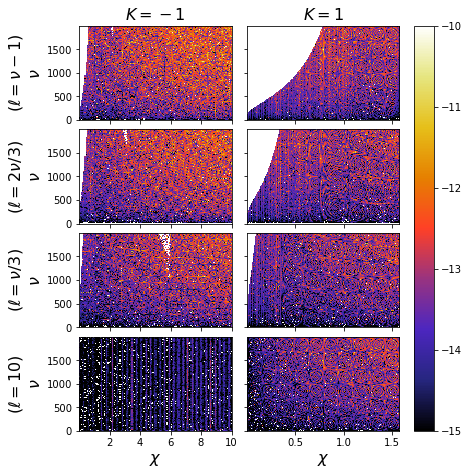

In [13]:
#'CMRmap'
lfracs = ['nu_minus_one',2./3,1./3,'ten']
fig, axes = plt.subplots(len(lfracs),2,sharex='col',sharey=True,figsize=(figwidth2,1.5*figheight2))
plt.colormaps()
models = ['Open','Closed']
for idx_g,geometry in enumerate(models):
    if geometry=='Open':
        x = chi_over_tp_OPEN
        y = nu_OPEN
        Z = reldif_OPEN
    else:
        x = chi_CLOSED
        y = nu_CLOSED
        Z = reldif_CLOSED
        
    for idxl, lfrac in enumerate(lfracs):
        #cont1 = axes[idxl,idx_g].pcolormesh(x,y,np.log10(Z[idxl,:,:]),vmin=-15,vmax=-10,cmap='CMRmap')
        cont1 = axes[idxl,idx_g].imshow(np.log10(Z[idxl,:,:]),
                                            vmin=-15,vmax=-10,cmap='CMRmap',
                                            extent=[min(x),max(x),min(y),max(y)],
                                           aspect='auto',origin='lower',interpolation='none')
        axes[idxl,idx_g].set_ylim([0,max(y)])
        axes[idxl,idx_g].set_xlim([min(x),max(x)])
        
        ['nu_minus_one',2./3,1./3,'ten']
for idxl, lfrac in enumerate(lfracs):
    if lfrac=='nu_minus_one':
        llab = r'\nu-1'
    elif lfrac=='ten':
        llab = r'10'
    elif lfrac==1./3:
        llab = r'\nu/3'
    else:       
        llab = r'2\nu/3'
    print(llab)
    axes[idxl,0].set_ylabel(r'$(\ell='+llab+')$\n'+r'$\nu$',fontsize=labelfs)
for idx_g,geometry in enumerate(models):
    if geometry=='Open':
        K=-1
        chilab = r'$\chi/\chi_\mathrm{tp}$'
    else:
        K=1
        chilab = r'$\chi$'
    axes[0,idx_g].set_title(r'$K='+str(K)+'$',fontsize=labelfs)
    axes[-1,idx_g].set_xlabel(r'$\chi$',fontsize=labelfs)
    
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.1,hspace=0.1)
fig.colorbar(cont1,ax=[element for element in axes.flat],fraction=1.5*0.046, pad=0.04)
fig.savefig('hyper_accuracy.pdf',bbox_inches='tight')

In [14]:
K=-1
#nu,l,chi = 2405, 1603, 1.6452708567350125
nu,l,chi = 2405, 1603, 1.65
chivec = np.linspace(chi,chi+0.003,25)
chivec = chivec+0.5*(chivec[1]-chivec[0])
chivec = chivec[:-1]

PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,chivec)
PhiMP=hyperspherical_combined(K,nu,l,chivec)
#clear_output()

(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6500624999999998].
Recurrence method gives Phi= 9.813387311230825e-05
(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6501875].
Recurrence method gives Phi= 0.00013329953888261003
(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6503125].
Recurrence method gives Phi= 0.00015733978322967764
(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6504374999999998].
Recurrence method gives Phi= 0.00016825260278688093
(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6508124999999998].
Recurrence method gives Phi= 0.00011898932788449196
(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6509375].
Recurrence method gives Phi= 7.982352923614079e-05
(1, 1604)
Both hyp2f1 and legenp failed to converge for (nu,l,chi)=[2405, 1603, 1.6514374999999997].
Recurrence

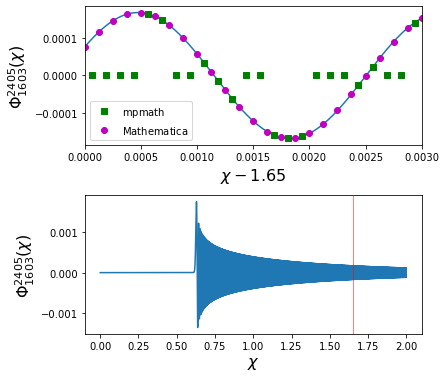

In [15]:
fig, axes = plt.subplots(2,1,figsize=(figwidth2,1.2*figheight2))
#chivecRec = np.linspace(0,3*chi,5000)
chivecRec = np.linspace(chi,chi+0.003,500)
PhiRec = cosmo.hyperspherical_recurrence(l,nu,K,chivecRec)

chi2 = np.linspace(1e-6,2,50000)
PhiRec2 = cosmo.hyperspherical_recurrence(l,nu,K,chi2)

#Read output from Mathematica
chiM = np.loadtxt('chivec.dat')
PhiM = np.loadtxt('phivec.dat')

axes[0].plot(chivecRec-chi,PhiRec[:,-1])
#plt.plot(chivec-chi,PhiMP,lw=3)
mask = np.isnan(PhiMP)
ms = 10
#axes[0].plot(chivec[~mask]-chi,PhiMP[~mask],linestyle='none',markeredgecolor='green',marker='o',
#             markerfacecolor='green',markersize=ms)
axes[0].plot(chivec[~mask]-chi,PhiMP[~mask],'gs',label=r'$\mathrm{mpmath}$')
axes[0].plot(chivec[mask]-chi,np.zeros(chivec[mask].shape),'gs')

axes[0].plot(chiM-chi,PhiM,'mo',label=r'$\mathrm{Mathematica}$')
axes[0].set_xlim([0.,0.003])
axes[0].legend(loc='lower left')

axes[1].plot(chi2,PhiRec2[:,-1])
axes[1].axvspan(min(chivec), max(chivec), alpha=0.5, color='red',zorder=100)


axes[0].set_xlabel(r'$\chi-1.65$',fontsize=labelfs)
axes[1].set_xlabel(r'$\chi$',fontsize=labelfs)

for ax in axes:
    ax.set_ylabel(r'$\Phi_{1603}^{2405}(\chi)$',fontsize=labelfs)

fig.tight_layout()
fig.savefig('hyper_fail.pdf',bbox_inches='tight')
#plt.plot(0.0022,-0.00004881302059,'mo')

In [16]:
%timeit cosmo.hyperspherical_recurrence(l,nu,K,chi2)
chivecRec = np.linspace(chi,chi+0.003,250000)
%timeit cosmo.hyperspherical_recurrence(l,nu,K,chivecRec)

645 ms ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.77 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
np.savetxt("chi_over_tp_OPEN.dat",chi_over_tp_OPEN)
np.savetxt("chi_CLOSED.dat",chi_CLOSED)
for idxl, lfrac in enumerate(lfracs):
    np.savetxt("reldif_OPEN_"+str(idxl)+".dat",reldif_OPEN[idxl,:,:])
    np.savetxt("reldif_CLOSED_"+str(idxl)+".dat",reldif_CLOSED[idxl,:,:])
np.savetxt("nu_OPEN.dat",nu_OPEN)
np.savetxt("nu_CLOSED.dat",nu_CLOSED)

